In [4]:
import seaborn as sb
import matplotlib.pyplot as plt 
import warnings
import pandas as pd
import numpy as np
import requests
import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from PIL import Image
from IPython.display import display
import cv2
from PIL import ImageFile
import torchvision.transforms as transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True

import glob
import os
import random
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

if(True):
  #link to google drive
  from google.colab import drive
  drive.mount('/content/drive')

if(True):
  #unzip data
  import zipfile
  path_to_zip_file = r'/content/drive/MyDrive/UTD/.UTD 2022 Fall/CS 4372/dog-breed-identification.zip'
  directory_to_extract_to = "dog-breed-identification"
  !mkdir "dog-breed-identification"
  with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
      zip_ref.extractall(directory_to_extract_to)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘dog-breed-identification’: File exists


In [5]:
%cd "/content/dog-breed-identification"

labels = pd.read_csv('labels.csv')
labelnames = pd.read_csv('sample_submission.csv')

print(f"There are {len(labelnames)} label names")
print(labelnames.head(5).to_string())
print()
print(f"There are {len(labels)} labels")
print(labels.head(5).to_string())
# from the looks of the csv file;, it is
# given a submission [identified by id], gives probabilities [in the columns] of being [column title]

/content/dog-breed-identification
There are 10357 label names
                                 id  affenpinscher  afghan_hound  african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  australian_terrier   basenji    basset    beagle  bedlington_terrier  bernese_mountain_dog  black-and-tan_coonhound  blenheim_spaniel  bloodhound  bluetick  border_collie  border_terrier    borzoi  boston_bull  bouvier_des_flandres     boxer  brabancon_griffon    briard  brittany_spaniel  bull_mastiff     cairn  cardigan  chesapeake_bay_retriever  chihuahua      chow   clumber  cocker_spaniel    collie  curly-coated_retriever  dandie_dinmont     dhole     dingo  doberman  english_foxhound  english_setter  english_springer  entlebucher  eskimo_dog  flat-coated_retriever  french_bulldog  german_shepherd  german_short-haired_pointer  giant_schnauzer  golden_retriever  gordon_setter  great_dane  great_pyrenees  greater_swiss_mountain_dog  groenendael  ibizan_hound  irish_setter  irish_terr

In [ ]:
#print test images
#this cell is a testing cell
if(False):
  %cd "train"
  fileDir = "." #'dog-breed-identification/train'
  listOfCuteDogImages = [os.path.join(fileDir, _) for _ in os.listdir(fileDir)]
  #print(listOfCuteDogImages[0:3]) #print first 3 image filename

  for imageName in listOfCuteDogImages[7:11]: #plot images of 7th to 11th dog
    print (os.path.join(imageName))
    img = cv2.imread(os.path.join(imageName))
    #print(img) #this shows numbers..
    img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cvt)
    plt.show()
  %cd ..

In [7]:
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
labels['target'] =  [breed_to_code[x] for x in labels.breed]
labels['rank'] = labels.groupby('breed').rank()['id']
#labels = labels[0:1000] #testing
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

#split into training samples and testing samples (valid)
train = labels_pivot.sample(frac=0.85)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

n_epochs = 10

(8689, 121) (1533, 121)


In [8]:
import pickle
from os.path import exists
pickleFilname = f'/content/drive/MyDrive/UTD/.UTD 2022 Fall/CS 4372/model_transfer_{train.shape[0]}images{n_epochs}epochs.pkl'

if( exists(pickleFilname ) ):
    with open(pickleFilname , 'rb') as f:
        model_transfer= pickle.load(f)

### Data

In [9]:
print(train.head(5).to_string())
listOfTrain = list(train['id']) #list training data, without ".jpg"

breed                                id  affenpinscher  afghan_hound  african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  australian_terrier  basenji  basset  beagle  bedlington_terrier  bernese_mountain_dog  black-and-tan_coonhound  blenheim_spaniel  bloodhound  bluetick  border_collie  border_terrier  borzoi  boston_bull  bouvier_des_flandres  boxer  brabancon_griffon  briard  brittany_spaniel  bull_mastiff  cairn  cardigan  chesapeake_bay_retriever  chihuahua  chow  clumber  cocker_spaniel  collie  curly-coated_retriever  dandie_dinmont  dhole  dingo  doberman  english_foxhound  english_setter  english_springer  entlebucher  eskimo_dog  flat-coated_retriever  french_bulldog  german_shepherd  german_short-haired_pointer  giant_schnauzer  golden_retriever  gordon_setter  great_dane  great_pyrenees  greater_swiss_mountain_dog  groenendael  ibizan_hound  irish_setter  irish_terrier  irish_water_spaniel  irish_wolfhound  italian_greyhound  japanese_spaniel  keesho

In [10]:
print(valid.head(5).to_string())
listOfTest = list(valid['id']) #list of testing data, without ".jpg"

breed                                id  affenpinscher  afghan_hound  african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  australian_terrier  basenji  basset  beagle  bedlington_terrier  bernese_mountain_dog  black-and-tan_coonhound  blenheim_spaniel  bloodhound  bluetick  border_collie  border_terrier  borzoi  boston_bull  bouvier_des_flandres  boxer  brabancon_griffon  briard  brittany_spaniel  bull_mastiff  cairn  cardigan  chesapeake_bay_retriever  chihuahua  chow  clumber  cocker_spaniel  collie  curly-coated_retriever  dandie_dinmont  dhole  dingo  doberman  english_foxhound  english_setter  english_springer  entlebucher  eskimo_dog  flat-coated_retriever  french_bulldog  german_shepherd  german_short-haired_pointer  giant_schnauzer  golden_retriever  gordon_setter  great_dane  great_pyrenees  greater_swiss_mountain_dog  groenendael  ibizan_hound  irish_setter  irish_terrier  irish_water_spaniel  irish_wolfhound  italian_greyhound  japanese_spaniel  keesho

In [11]:
img_transform = {
    'valid':transforms.Compose([
        transforms.Resize(size = 256, interpolation = transforms.InterpolationMode.NEAREST),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'train':transforms.Compose([
       transforms.RandomResizedCrop(size = 256, interpolation = transforms.InterpolationMode.NEAREST),
        transforms.RandomRotation(degrees = 30),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    'test':transforms.Compose([
        transforms.Resize(size = 256, interpolation = transforms.InterpolationMode.NEAREST),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [12]:
class DogBreedDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, img_dir, label, transform):
        'Initialization'
        self.img_dir = img_dir
        self.transform = transform
        self.label = label

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.label)

    def __getitem__(self, index):
        if self.label is not None:
            img_name = '{}.jpg'.format(self.label.iloc[index, 0])
            fullname = self.img_dir + img_name
            image = Image.open(fullname)
            label = self.label.iloc[index, 1:].astype('float').to_numpy()
            label = np.argmax(label)
            if self.transform:
                image = self.transform(image)
            return [image, label]

In [13]:
batch_size = 12
num_workers = 4
train_img = DogBreedDataset('/content/dog-breed-identification/train/', train, transform = img_transform['train'])
valid_img = DogBreedDataset('/content/dog-breed-identification/train/', valid, transform = img_transform['valid'])


dataloaders={
    'train':torch.utils.data.DataLoader(train_img, batch_size, num_workers = num_workers, shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_img, batch_size, num_workers = num_workers, shuffle=False)
}

In [14]:
train_img.transform

Compose(
    RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=nearest), antialias=None)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
    RandomHorizontalFlip(p=0.5)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [15]:
use_cuda = torch.cuda.is_available()

In [16]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

In [17]:
type(dataloaders['train'])

torch.utils.data.dataloader.DataLoader

torch.Size([12, 3, 224, 224]) torch.Size([12])


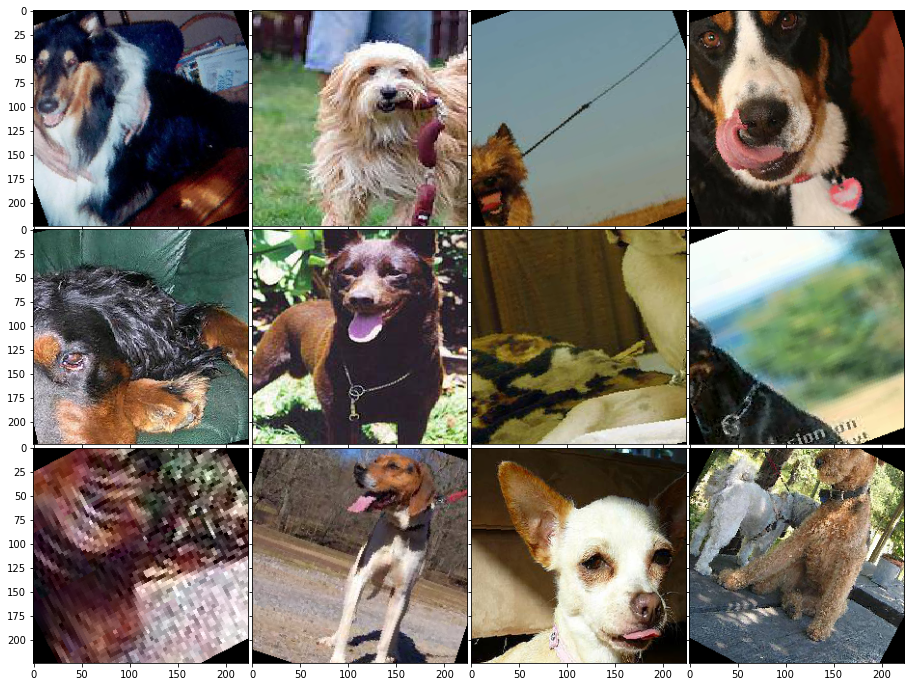

In [18]:
from mpl_toolkits.axes_grid1 import ImageGrid
img, label = next(iter(dataloaders['train']))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

### Transfer Learning and Parameter Tuning

In [19]:
##  Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.parameters():
  #print(param)
  param.requires_grad = False
    
# replace the last fully connected layer with a Linnear layer 133 output
in_features = model_transfer.fc.in_features     # in_features = 2048
model_transfer.fc = nn.Linear(in_features, 120) # Linear(in_features=2048, out_features=120, bias=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [20]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch: %d \tBatch: %d \tTraining Loss: %.6f' %(epoch, batch_idx + 1, train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('BOOM! Validation loss decreased ({:.4f} --> {:.4f}).  Saving model...'.format(valid_loss_min,valid_loss))
            valid_loss_min = valid_loss    

    # return trained model
    return model

In [21]:
criterion_transfer = nn.CrossEntropyLoss()
model_transfer_grad_paramaters = filter(lambda p: p.requires_grad, model_transfer.parameters())
optimizer_transfer = torch.optim.SGD(model_transfer_grad_paramaters, lr=0.01) #activation

In [22]:
# train the model
model_transfer = train(n_epochs, dataloaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
#model_transfer = '/content/drive/MyDrive/UTD/.UTD 2022 Fall/CS 4372/model_transfer_8689images5epochs.pkl'

Epoch: 1 	Batch: 1 	Training Loss: 5.020816
Epoch: 1 	Batch: 101 	Training Loss: 4.760890
Epoch: 1 	Batch: 201 	Training Loss: 4.610265
Epoch: 1 	Batch: 301 	Training Loss: 4.471393
Epoch: 1 	Batch: 401 	Training Loss: 4.352954
Epoch: 1 	Batch: 501 	Training Loss: 4.239493
Epoch: 1 	Batch: 601 	Training Loss: 4.130750
Epoch: 1 	Batch: 701 	Training Loss: 4.028944
Epoch: 1 	Training Loss: 4.0057 	Validation Loss: 2.8092
BOOM! Validation loss decreased (inf --> 2.8092).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 3.767642
Epoch: 2 	Batch: 101 	Training Loss: 3.151774
Epoch: 2 	Batch: 201 	Training Loss: 3.097889
Epoch: 2 	Batch: 301 	Training Loss: 3.045805
Epoch: 2 	Batch: 401 	Training Loss: 3.001635
Epoch: 2 	Batch: 501 	Training Loss: 2.946314
Epoch: 2 	Batch: 601 	Training Loss: 2.898628
Epoch: 2 	Batch: 701 	Training Loss: 2.854832
Epoch: 2 	Training Loss: 2.8484 	Validation Loss: 1.6546
BOOM! Validation loss decreased (2.8092 --> 1.6546).  Saving model...
Epoch: 3 	Batch: 

In [ ]:
f=""" 1000 pictures, 3 epochs:
Epoch: 1 	Batch: 1 	Training Loss: 4.820606
Epoch: 1 	Training Loss: 4.7854 	Validation Loss: 4.6281
BOOM! Validation loss decreased (inf --> 4.6281).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 4.775223
Epoch: 2 	Training Loss: 4.4801 	Validation Loss: 4.3470
BOOM! Validation loss decreased (4.6281 --> 4.3470).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 4.042047
Epoch: 3 	Training Loss: 4.2297 	Validation Loss: 4.0708
BOOM! Validation loss decreased (4.3470 --> 4.0708).  Saving model...
"""

f2=""" 5000 pictures, 3 epochs:
Epoch: 1 	Batch: 1 	Training Loss: 4.832945
Epoch: 1 	Batch: 101 	Training Loss: 4.741760
Epoch: 1 	Batch: 201 	Training Loss: 4.606566
Epoch: 1 	Batch: 301 	Training Loss: 4.474421
Epoch: 1 	Training Loss: 4.4165 	Validation Loss: 3.4888
BOOM! Validation loss decreased (inf --> 3.4888).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 3.961325
Epoch: 2 	Batch: 101 	Training Loss: 3.838313
Epoch: 2 	Batch: 201 	Training Loss: 3.725471
Epoch: 2 	Batch: 301 	Training Loss: 3.628852
Epoch: 2 	Training Loss: 3.5870 	Validation Loss: 2.5023
BOOM! Validation loss decreased (3.4888 --> 2.5023).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 3.083075
Epoch: 3 	Batch: 101 	Training Loss: 3.201915
Epoch: 3 	Batch: 201 	Training Loss: 3.128031
Epoch: 3 	Batch: 301 	Training Loss: 3.071620
Epoch: 3 	Training Loss: 3.0465 	Validation Loss: 1.9330
BOOM! Validation loss decreased (2.5023 --> 1.9330).  Saving model..."""

f3=""" All 10222 pictures, 3 epochs:
Epoch: 1 	Batch: 1 	Training Loss: 4.947224
Epoch: 1 	Batch: 101 	Training Loss: 4.723919
Epoch: 1 	Batch: 201 	Training Loss: 4.587653
Epoch: 1 	Batch: 301 	Training Loss: 4.468295
Epoch: 1 	Batch: 401 	Training Loss: 4.346153
Epoch: 1 	Batch: 501 	Training Loss: 4.230396
Epoch: 1 	Batch: 601 	Training Loss: 4.116463
Epoch: 1 	Batch: 701 	Training Loss: 4.006574
Epoch: 1 	Training Loss: 3.9866 	Validation Loss: 2.7904
BOOM! Validation loss decreased (inf --> 2.7904).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 3.871949
Epoch: 2 	Batch: 101 	Training Loss: 3.147888
Epoch: 2 	Batch: 201 	Training Loss: 3.082691
Epoch: 2 	Batch: 301 	Training Loss: 3.044378
Epoch: 2 	Batch: 401 	Training Loss: 2.997859
Epoch: 2 	Batch: 501 	Training Loss: 2.940052
Epoch: 2 	Batch: 601 	Training Loss: 2.892384
Epoch: 2 	Batch: 701 	Training Loss: 2.848122
Epoch: 2 	Training Loss: 2.8419 	Validation Loss: 1.6031
BOOM! Validation loss decreased (2.7904 --> 1.6031).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 2.792788
Epoch: 3 	Batch: 101 	Training Loss: 2.471815
Epoch: 3 	Batch: 201 	Training Loss: 2.474647
Epoch: 3 	Batch: 301 	Training Loss: 2.458736
Epoch: 3 	Batch: 401 	Training Loss: 2.411387
Epoch: 3 	Batch: 501 	Training Loss: 2.375977
Epoch: 3 	Batch: 601 	Training Loss: 2.349866
Epoch: 3 	Batch: 701 	Training Loss: 2.331016
Epoch: 3 	Training Loss: 2.3327 	Validation Loss: 1.2304
BOOM! Validation loss decreased (1.6031 --> 1.2304).  Saving model...
"""

f4 = """ All 10222 pictures, 5 epochs
Epoch: 1 	Batch: 1 	Training Loss: 4.886767
Epoch: 1 	Batch: 101 	Training Loss: 4.729091
Epoch: 1 	Batch: 201 	Training Loss: 4.608284
Epoch: 1 	Batch: 301 	Training Loss: 4.482468
Epoch: 1 	Batch: 401 	Training Loss: 4.352062
Epoch: 1 	Batch: 501 	Training Loss: 4.239295
Epoch: 1 	Batch: 601 	Training Loss: 4.125138
Epoch: 1 	Batch: 701 	Training Loss: 4.019838
Epoch: 1 	Training Loss: 3.9988 	Validation Loss: 2.6609
BOOM! Validation loss decreased (inf --> 2.6609).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 3.521045
Epoch: 2 	Batch: 101 	Training Loss: 3.167631
Epoch: 2 	Batch: 201 	Training Loss: 3.127581
Epoch: 2 	Batch: 301 	Training Loss: 3.069848
Epoch: 2 	Batch: 401 	Training Loss: 3.006356
Epoch: 2 	Batch: 501 	Training Loss: 2.958204
Epoch: 2 	Batch: 601 	Training Loss: 2.906377
Epoch: 2 	Batch: 701 	Training Loss: 2.867462
Epoch: 2 	Training Loss: 2.8605 	Validation Loss: 1.6696
BOOM! Validation loss decreased (2.6609 --> 1.6696).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 3.659420
Epoch: 3 	Batch: 101 	Training Loss: 2.491639
Epoch: 3 	Batch: 201 	Training Loss: 2.491406
Epoch: 3 	Batch: 301 	Training Loss: 2.451811
Epoch: 3 	Batch: 401 	Training Loss: 2.420945
Epoch: 3 	Batch: 501 	Training Loss: 2.407779
Epoch: 3 	Batch: 601 	Training Loss: 2.376457
Epoch: 3 	Batch: 701 	Training Loss: 2.362266
Epoch: 3 	Training Loss: 2.3613 	Validation Loss: 1.1551
BOOM! Validation loss decreased (1.6696 --> 1.1551).  Saving model...
Epoch: 4 	Batch: 1 	Training Loss: 3.070820
Epoch: 4 	Batch: 101 	Training Loss: 2.260064
Epoch: 4 	Batch: 201 	Training Loss: 2.200973
Epoch: 4 	Batch: 301 	Training Loss: 2.158476
Epoch: 4 	Batch: 401 	Training Loss: 2.162050
Epoch: 4 	Batch: 501 	Training Loss: 2.149412
Epoch: 4 	Batch: 601 	Training Loss: 2.124513
Epoch: 4 	Batch: 701 	Training Loss: 2.121198
Epoch: 4 	Training Loss: 2.1222 	Validation Loss: 1.0137
BOOM! Validation loss decreased (1.1551 --> 1.0137).  Saving model...
Epoch: 5 	Batch: 1 	Training Loss: 2.786750
Epoch: 5 	Batch: 101 	Training Loss: 2.002395
Epoch: 5 	Batch: 201 	Training Loss: 2.019095
Epoch: 5 	Batch: 301 	Training Loss: 1.968766
Epoch: 5 	Batch: 401 	Training Loss: 1.972471
Epoch: 5 	Batch: 501 	Training Loss: 1.960163
Epoch: 5 	Batch: 601 	Training Loss: 1.957953
Epoch: 5 	Batch: 701 	Training Loss: 1.960859
Epoch: 5 	Training Loss: 1.9660 	Validation Loss: 0.9232
BOOM! Validation loss decreased (1.0137 --> 0.9232).  Saving model...
"""

In [27]:
import pickle
from os.path import exists
pickleFilname = f'/content/drive/MyDrive/UTD/.UTD 2022 Fall/CS 4372/model_transferAllImages{n_epochs}epochs.pkl'

if( exists(pickleFilname ) ):
    with open(pickleFilname , 'rb') as f:
        model_transfer= pickle.load(f)

with open(pickleFilname , 'wb') as f:
    pickle.dump(model_transfer, f) 

In [23]:
# model_transfer
from PIL import Image

if (False): #this is a testing cell
  #filePath = '/content/dog-breed-identification/train/0a3f1898556115d6d0931294876cd1d9.jpg' = maltese dog   3 epoch, 1000 images
  #filePath = '/content/dog-breed-identification/train/0b97116ed04c8f0f7eb4a2b4b2620476.jpg' = samoyed (ish) 3 epoch, 1000 images
  filePath = '/content/dog-breed-identification/train/0d103ca7cf575757374f8f6ae87d8868.jpg' #= miniature_pinscher 3 epoch, 10222 images
  img_dog = Image.open(filePath).convert('RGB')
  from torchvision import transforms

  # Create a preprocessing pipeline
  preprocess = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )])

  # Pass the image for preprocessing and the image preprocessed
  # Reshape, crop, and normalize the input tensor for feeding into network for evaluation
  img_dog_preprocessed = preprocess(img_dog)
  batch_img_dog_tensor = torch.unsqueeze(img_dog_preprocessed, 0)

  prediction = model_transfer.forward(batch_img_dog_tensor)
  print(prediction)

  list(prediction)[0]
  list(list(prediction)[0])
  prediction.shape

In [ ]:
if(False): #this is a testing cell
  model_transfer.eval()
  out = model_transfer(batch_img_dog_tensor)
  _, index = torch.max(out, 1)

  print("index:", index)
  percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
  print()
  print(percentage)
  newLabels = list(labels['target'])
  # Print the name along with score of the object identified by the model

  print(newLabels[index[0]], percentage[index[0]].item())

  # Print the top 5 scores along with the image label. Sort function is invoked on the torch to sort the scores.

  _, indices = torch.sort(out, descending=True)
  [(newLabels[idx], percentage[idx].item()) for idx in indices[0][:5]]
  print("predicted label:", labelnames.columns[index+1])

In [24]:
def identifyDog(file, df, bShow = False):
  img_dog = Image.open(file).convert('RGB')
  #preprocessing pipeline
  preprocess = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )])
  img_dog_preprocessed = preprocess(img_dog)
  batch_img_dog_tensor = torch.unsqueeze(img_dog_preprocessed, 0)

  #create prediction array
  prediction = model_transfer.forward(batch_img_dog_tensor)
  list(prediction)[0]
  list(list(prediction)[0])

  #pick out the most likely breed from predictions
  model_transfer.eval()
  out = model_transfer(batch_img_dog_tensor)
  _, index = torch.max(out, 1)

  #choose the label that matches the index
  percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
  newLabels = list(labels['target'])

  #find actual breed in label csv
  theId = file.split('/')[-1].replace('.jpg','')
  theBreed = list(labels[labels['id'].str.contains(theId)]['breed'])[0]

  #print prediction and actual breed
  predBreed = labelnames.columns[index+1]
  #print("Predicted dog breed:", predBreed)
  #print("Actual dog breed:", theBreed)
  
  dict = { "Actual Label": theBreed, "Predicted Label": predBreed, "Match": "True" if theBreed == predBreed else "False"}
  df = df.append(dict, ignore_index = True)

  if(bShow):
  #plot dog image
    img = cv2.imread(file)
    img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cvt)
    plt.show()
  
  bSuccess = True

  #if prediction is wrong, plot the predicted dog
  if(theBreed != predBreed):
    bSuccess = False
    if(bShow):
      #print(f"The predicted breed is wrong. Here is what a {predBreed} normally looks like.")
      #find what the predicted breed is
      thePredBreedId = list(labels[labels['breed'].str.contains(predBreed)]['id'])[0]
      #plot that dog
      file = f"/content/dog-breed-identification/train/{thePredBreedId}.jpg"
      img = cv2.imread(file)
      img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.imshow(img_cvt)
      plt.show()
  
  return df, bSuccess

In [25]:
df = pd.DataFrame()
numCorrects = 0
numWrongs = 0

numImages = 1500
for id in listOfTest[0:numImages]:
  filePath = f"/content/dog-breed-identification/train/{id}.jpg"
  df, bSuccess = identifyDog(filePath, df)
  if(bSuccess):
    numCorrects += 1
  else:
    numWrongs += 1

accuracy = numCorrects/(numCorrects+numWrongs)
print("Number of correct predictions: ", numCorrects)
print("Number of incorrect predictions: ", numWrongs)
print(f"Accuracy of the model for {numImages} dogs: ","{:.2f}%".format(accuracy*100))
print(df.to_string())

Number of correct predictions:  1153
Number of incorrect predictions:  347
Accuracy of the model for 1500 dogs:  76.87%
                        Actual Label                 Predicted Label  Match
0                        boston_bull                     boston_bull   True
1                              dingo                           dingo   True
2                           pekinese                     maltese_dog  False
3                 bedlington_terrier              bedlington_terrier   True
4                 bedlington_terrier              bedlington_terrier   True
5                   golden_retriever                golden_retriever   True
6                 standard_schnauzer              standard_schnauzer   True
7                irish_water_spaniel                        doberman  False
8            black-and-tan_coonhound         black-and-tan_coonhound   True
9                 labrador_retriever              labrador_retriever   True
10                       groenendael        